In [43]:
# Installing dependencies 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [44]:
# Fetching the preprocessed data as 'posts' and 'labels' to be used also

posts = []  
labels = [] 

folders = {
    "depression": {
        "path": "data/preprocessed/preprocessed_depression_posts",
        "label": 1  # Label for depression-related posts
    },
    "breastcancer": {
        "path": "data/preprocessed/preprocessed_breastcancer_posts",
        "label": 0  # Label for breast cancer posts
    }
}

for category, data in folders.items():
    folder_path = data["path"]
    label = data["label"]
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()  # Read the file content
                posts.append(content)  # Add to postst list
                labels.append(label)  # Add corresponding label


## TODO: SVM (x6)

### SVM on unigram data

In [53]:
# SVM on unigram data

# Load the unigram features and labels
unigram_data_file = "data/feature_extracted_data/unigram_features_with_labels.csv"  # Update path if needed
unigram_df = pd.read_csv(unigram_data_file)

# Separate features and labels
X = unigram_df.iloc[:, :-1].values  # All columns except the last one are features
y = unigram_df.iloc[:, -1].values  # The last column is the label

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Use a linear kernel for interpretability
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9659090909090909

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.96      1.00      0.98        72

    accuracy                           0.97        88
   macro avg       0.98      0.91      0.94        88
weighted avg       0.97      0.97      0.96        88



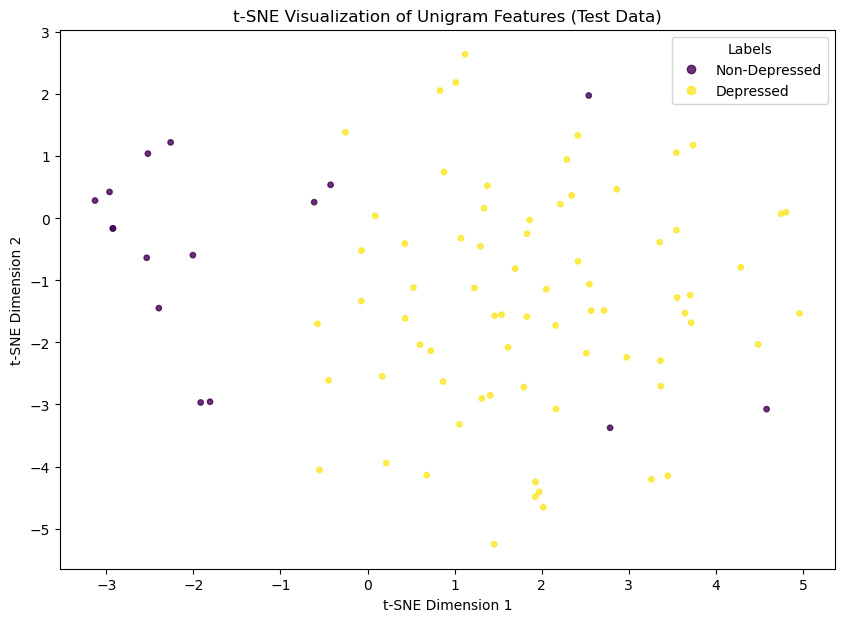

In [47]:
# Visualisation of the unigram feature distribution using t-SNE

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)  # Apply t-SNE to test data

# Visualize the results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis', s=15, alpha=0.8)
plt.title("t-SNE Visualization of Unigram Features (Test Data)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add legend for the labels
plt.legend(handles=scatter.legend_elements()[0], labels=["Non-Depressed", "Depressed"], title="Labels")
plt.show()

In [50]:
# Seeing which words are most important for the SVM model

# Get the coefficients and feature names
coefficients = svm_model.coef_.flatten()  # Coefficients for each feature
unigram_features = unigram_df.columns[:-1]  # Feature names (all except the last column)

# Create a DataFrame to pair unigrams with their coefficients
coef_df = pd.DataFrame({
    "Unigram": unigram_features,
    "Coefficient": coefficients
})

# Sort by coefficient values (absolute values indicate importance)
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Print top unigrams for depression (positive coefficients) and non-depression (negative coefficients)
print("Top Unigrams Associated with Depression:")
print(coef_df_sorted[coef_df_sorted["Coefficient"] > 0].head(10))

print("\nTop Unigrams Associated with Non-Depression:")
print(coef_df_sorted[coef_df_sorted["Coefficient"] < 0].head(10))

Top Unigrams Associated with Depression:
      Unigram  Coefficient
1075  depress     0.950539
2246     live     0.677608
1463     feel     0.666335
2220     life     0.664340
2228     like     0.662195
3562     ssri     0.657900
1930       im     0.626030
2279      lot     0.569230
3667   suicid     0.486921
2144     know     0.482355

Top Unigrams Associated with Non-Depression:
         Unigram  Coefficient
732        chemo    -1.082189
595       breast    -1.009221
666       cancer    -0.981749
3917   treatment    -0.967291
324      appoint    -0.846452
3210       round    -0.819470
4239       worri    -0.784582
2346  mastectomi    -0.769676
2628  oncologist    -0.763452
307        anyon    -0.694111


### SVM on bigrams

In [54]:
# SVM on bigram data
# Load the dataset
bigram_data_file = "data/feature_extracted_data/bigram_features_with_labels.csv"  # Adjust path if necessary
bigram_df = pd.read_csv(bigram_data_file)

# Separate features and labels
X = bigram_df.iloc[:, :-1].values  # All columns except the last one (features)
y = bigram_df['label'].values     # The last column contains the labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7966101694915254

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25        14
           1       0.79      1.00      0.88        45

    accuracy                           0.80        59
   macro avg       0.89      0.57      0.57        59
weighted avg       0.84      0.80      0.73        59



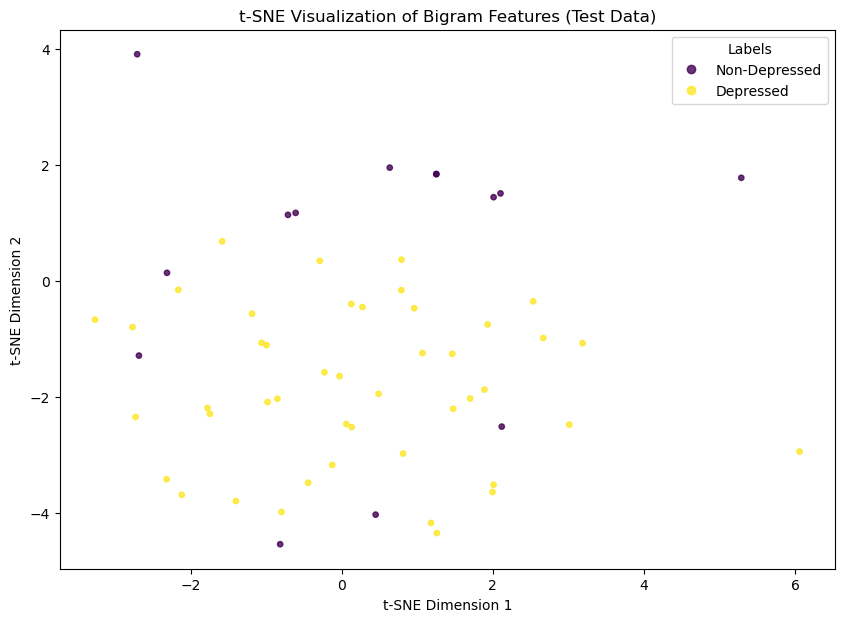

In [56]:
# Visualisation of the bigram feature distribution using t-SNE

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)  # Apply t-SNE to test data

# Visualize the results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis', s=15, alpha=0.8)
plt.title("t-SNE Visualization of Bigram Features (Test Data)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add legend for the labels
plt.legend(handles=scatter.legend_elements()[0], labels=["Non-Depressed", "Depressed"], title="Labels")
plt.show()

In [57]:
# Seeing which bigrams are most important for the SVM model
# Get the coefficients and feature names
coefficients = svm_model.coef_.flatten()  # Coefficients for each feature
bigram_features = bigram_df.columns[:-1]  # Feature names (all except the last column)

# Create a DataFrame to pair unigrams with their coefficients
coef_df = pd.DataFrame({
    "Unigram": bigram_features,
    "Coefficient": coefficients
})

# Sort by coefficient values (absolute values indicate importance)
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Print top unigrams for depression (positive coefficients) and non-depression (negative coefficients)
print("Top Bigrams Associated with Depression:")
print(coef_df_sorted[coef_df_sorted["Coefficient"] > 0].head(10))

print("\nTop Bigrams Associated with Non-Depression:")
print(coef_df_sorted[coef_df_sorted["Coefficient"] < 0].head(10))

Top Bigrams Associated with Depression:
              Unigram  Coefficient
9140        feel like     0.670115
20976     realli want     0.277178
28020          wan na     0.264314
16096       make feel     0.244642
9306        felt like     0.229027
24962  suicid thought     0.218785
16709   mental health     0.209502
14907       like noth     0.201238
22680   sever depress     0.200052
10427          gon na     0.190084

Top Bigrams Associated with Non-Depression:
                Unigram  Coefficient
15995        lymph node    -1.030699
1687          anyon els    -0.915013
15336         load dose    -0.605304
3503      breast cancer    -0.600161
17471      mutat burden    -0.552915
7568         els experi    -0.543740
1690       anyon experi    -0.540498
7151   doubl mastectomi    -0.536619
24087       stage grade    -0.532239
25032     support group    -0.512343


## TODO: MLP (x6) 

## TODO: LR (x6)

## TODO: RF (x6)

## TODO: ADA (x6)